In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
from os import path
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from tqdm import tqdm
import spacy
from wordcloud import WordCloud, STOPWORDS
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

In [82]:
# Reading the train.csv file
with open('train.csv') as file:
    data = pd.read_csv(file)

data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

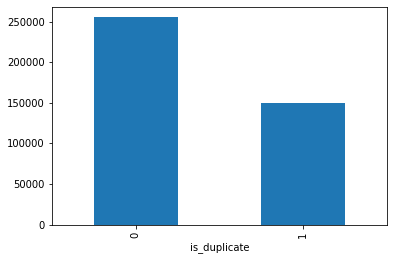

In [84]:
data.groupby("is_duplicate")['id'].count().plot.bar()

In [85]:
print('~> Total number of question pairs for training:\n   {}'.format(len(data)))

~> Total number of question pairs for training:
   404290


In [86]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(data['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(data['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


<h3> 3.2.2 Number of unique questions </h3>

In [87]:
qids = pd.Series(data['qid1'].tolist() + data['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



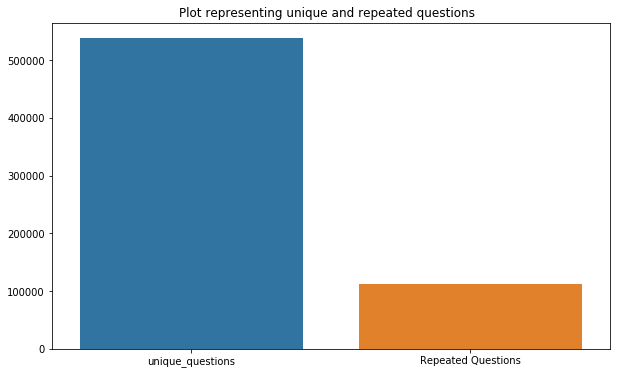

In [88]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3>3.2.3 Checking for Duplicates </h3>

In [89]:
#checking whether there are any repeated pair of questions

pair_duplicates = data[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - data.shape[0])

Number of duplicate questions 0


<h3> 3.2.4 Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 157



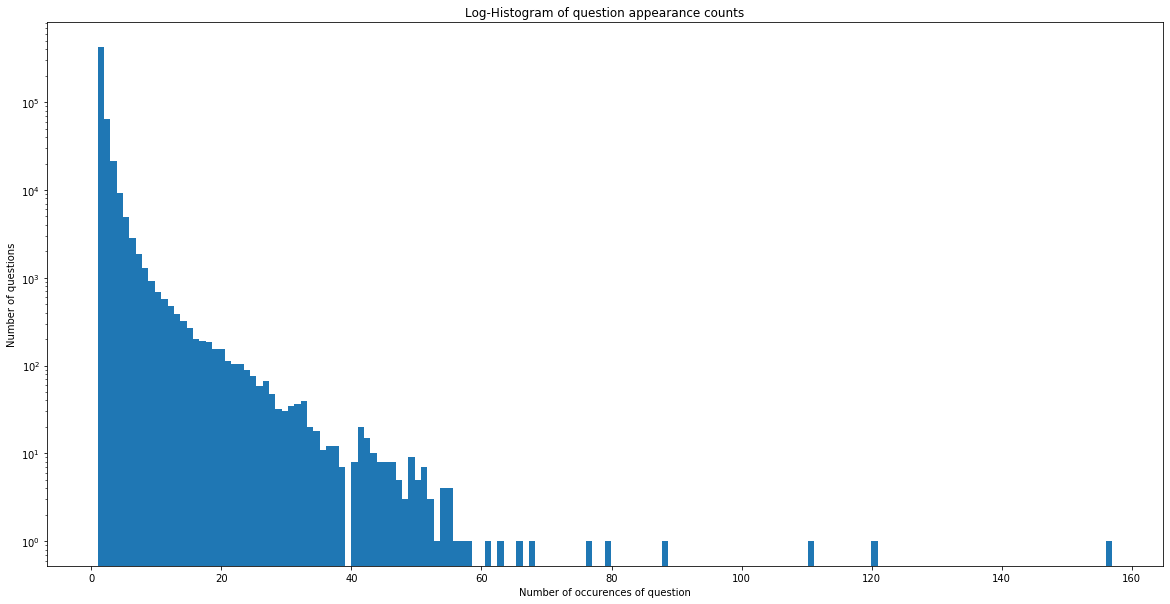

In [90]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<h3> 3.2.5 Checking for NULL values </h3>

In [91]:
#Checking whether there are any rows with null values
nan_rows = data[data.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


- There are two rows with null values in question2 

In [92]:
# Filling the null values with ' '
data = data.fillna('')
nan_rows = data[data.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [93]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    data = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    data['freq_qid1'] = data.groupby('qid1')['qid1'].transform('count') 
    data['freq_qid2'] = data.groupby('qid2')['qid2'].transform('count')
    data['q1len'] = data['question1'].str.len() 
    data['q2len'] = data['question2'].str.len()
    data['q1_n_words'] = data['question1'].apply(lambda row: len(row.split(" ")))
    data['q2_n_words'] = data['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    data['word_Common'] = data.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    data['word_Total'] = data.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    data['word_share'] = data.apply(normalized_word_share, axis=1)

    data['freq_q1+q2'] = data['freq_qid1']+data['freq_qid2']
    data['freq_q1-q2'] = abs(data['freq_qid1']-data['freq_qid2'])

    data.to_csv("df_fe_without_preprocessing_train.csv", index=False)

data.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


<h3> 3.3.1 Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [94]:
print ("Minimum length of the questions in question1 : " , min(data['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(data['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", data[data['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", data[data['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


<h4> 3.3.1.1 Feature: word_share </h4>

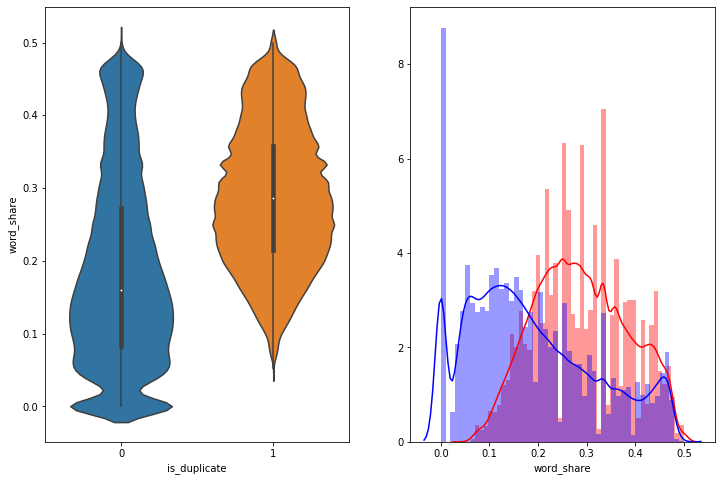

In [95]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = data[0:])

plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(data[data['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> 3.3.1.2 Feature: word_Common </h4>

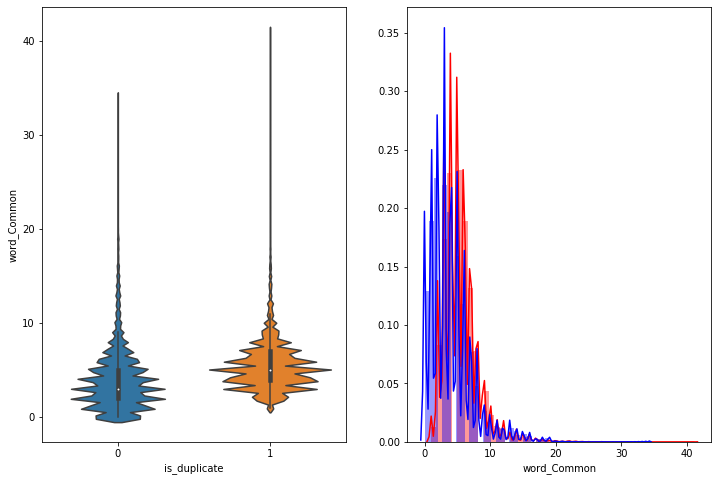

In [96]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = data[0:])

plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(data[data['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

In [97]:
#https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    data = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    data = data.fillna('')
    data.head()
else:
    print("get df_fe_without_preprocessing_train.csv from drive or run the previous notebook")

In [98]:
data.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


<h2> 3.4 Preprocessing of Text </h2>

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [99]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

<h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [100]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [101]:
if os.path.isfile('nlp_features_train.csv'):
    data = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    data.fillna('')
else:
    print("Extracting features for train:")
    data = pd.read_csv("train.csv")
    data = extract_features(data)
    data.to_csv("nlp_features_train.csv", index=False)
data.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


<h3>3.5.1 Analysis of extracted features </h3>

<h4> 3.5.1.1 Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [102]:
data_duplicate = data[data['is_duplicate'] == 1]
data_nonduplicate = data[data['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([data_duplicate["question1"], data_duplicate["question2"]]).flatten()
n = np.dstack([data_nonduplicate["question1"], data_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [103]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 33193130


__ Word Clouds generated from  duplicate pair question's text __

Word Cloud for Duplicate Question pairs


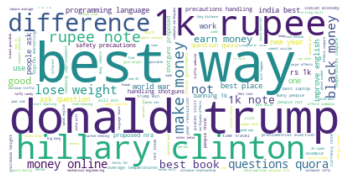

In [104]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

__ Word Clouds generated from non duplicate pair question's text __

Word Cloud for non-Duplicate Question pairs:


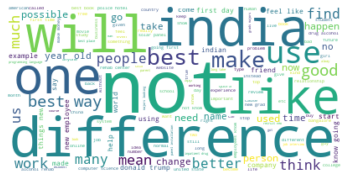

In [105]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h4> 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>

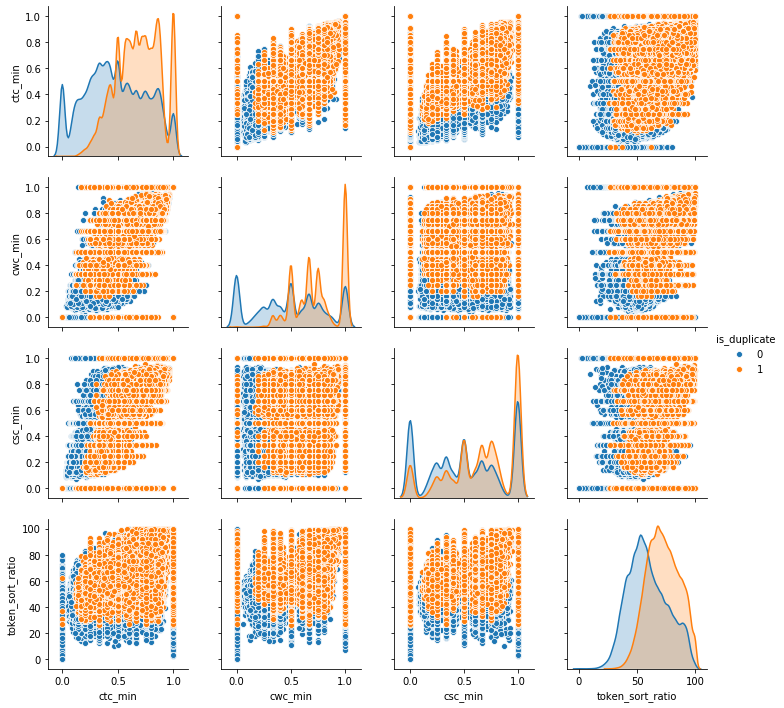

In [106]:
n = data.shape[0]
sns.pairplot(data[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

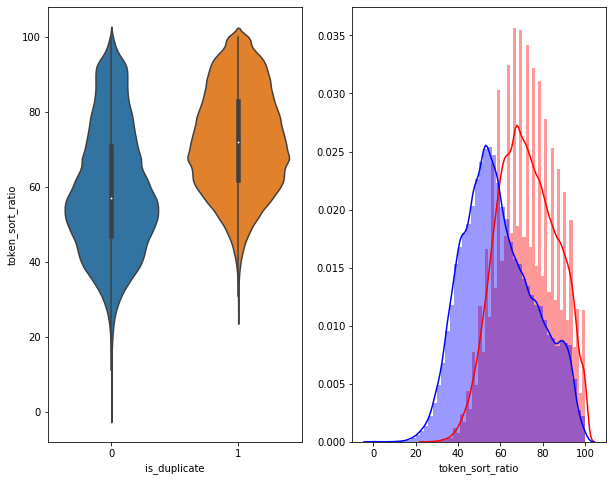

In [107]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = data[0:] , )

plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(data[data['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

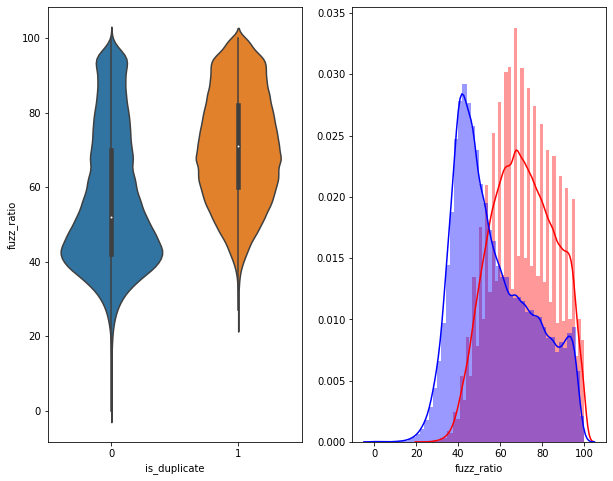

In [108]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = data[0:] , )

plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(data[data['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<h3>3.5.2 Visualization </h3>

In [109]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

data_subsampled = data[0:5000]
X = MinMaxScaler().fit_transform(data_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = data_subsampled['is_duplicate'].values

In [110]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.011s...
[t-SNE] Computed neighbors for 5000 samples in 0.357s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.312s
[t-SNE] Iteration 50: error = 80.9162369, gradient norm = 0.0427600 (50 iterations in 2.641s)
[t-SNE] Iteration 100: error = 70.3915100, gradient norm = 0.0108003 (50 iterations in 1.873s)
[t-SNE] Iteration 150: error = 68.6126938, gradient norm = 0.0054721 (50 iterations in 1.862s)
[t-SNE] Iteration 200: error = 67.7680206, gradient norm = 0.0042246 (50 iterations in 1.934s)
[t-SNE] Iteration 250: error = 67.2733459, gradient norm = 0.0037275

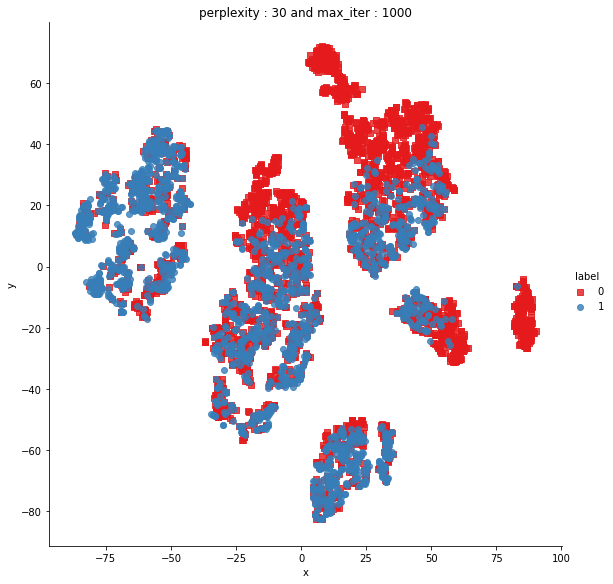

In [111]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [112]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.009s...
[t-SNE] Computed neighbors for 5000 samples in 0.352s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.310s
[t-SNE] Iteration 50: error = 80.3552017, gradient norm = 0.0329941 (50 iterations in 13.543s)
[t-SNE] Iteration 100: error = 69.1127167, gradient norm = 0.0034163 (50 iterations in 8.890s)
[t-SNE] Iteration 150: error = 67.6180878, gradient norm = 0.0017124 (50 iterations in 8.119s)
[t-SNE] Iteration 200: error = 67.0570450, gradient norm = 0.0011735 (50 iterations in 8.052s)
[t-SNE] Iteration 250: error = 66.7297211, gradient norm = 0.000904

In [113]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data_tsne=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data_tsne, layout=layout)
py.iplot(fig, filename='3DBubble')

In [114]:
# Function to sample the data
def sampling_data(data):
    data = data.sample(n=100000, replace=True)
    return data

In [115]:
# Function to split the train and test data
def test_train_spliting(x, y):
    x_train, y_train, x_test, y_test = train_test_split(x, y, test_size=0.3)
    return x_train, y_train, x_test, y_test

In [116]:
data = sampling_data(data)

# Filling the null values with ' '
data = data.fillna('')
nan_rows = data[data.isnull().any(1)]
print (nan_rows)
print(data.shape)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio]
Index: []

[0 rows x 21 columns]
(100000, 21)


In [117]:
data1 = data
y = data1['is_duplicate']
data1 = data1.drop('is_duplicate', axis=1)
print(data1.columns)
x_train, x_test, y_train, y_test = test_train_spliting(data1, y)

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'cwc_min', 'cwc_max',
       'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq',
       'first_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio',
       'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio',
       'longest_substr_ratio'],
      dtype='object')


In [118]:
def apply_tf_idf(train_df, test_df):
    
    # Train data
    train_question = train_df['question1'] + train_df['question2']
    
    train_special_feat = train_df[['cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio']]

    tfidf = TfidfVectorizer()
    
    train_question_vect = tfidf.fit_transform(train_question)
    
    word2tfidf_train = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
    
    train_question_vect = hstack([train_question_vect, train_special_feat])
    
    
    #Test data
    test_question = test_df['question1'] + test_df['question2']
    
    test_special_feat = test_df[['cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio']]
    
    test_question_vect = tfidf.transform(test_question)
    
    word2tfidf_test = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
    
    test_question_vect = hstack([test_question_vect, test_special_feat])
    
    return train_question_vect, test_question_vect, word2tfidf_train, word2tfidf_test 

In [119]:
print(x_train.shape)
print(x_test.shape)
train_vect, test_vect, word2tfidf_train, word2tfidf_test = apply_tf_idf(x_train, x_test)
print(train_vect.shape)
print(test_vect.shape)

(70000, 20)
(30000, 20)
(70000, 37830)
(30000, 37830)


In [120]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6320571428571429 Class 1:  0.3679428571428571
---------- Distribution of output variable in train data ----------
Class 0:  0.3688666666666667 Class 1:  0.3688666666666667


In [121]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

## Building a random model (Finding worst-case log-loss)

Log loss on Test Data using Random Model 0.8834040499422304


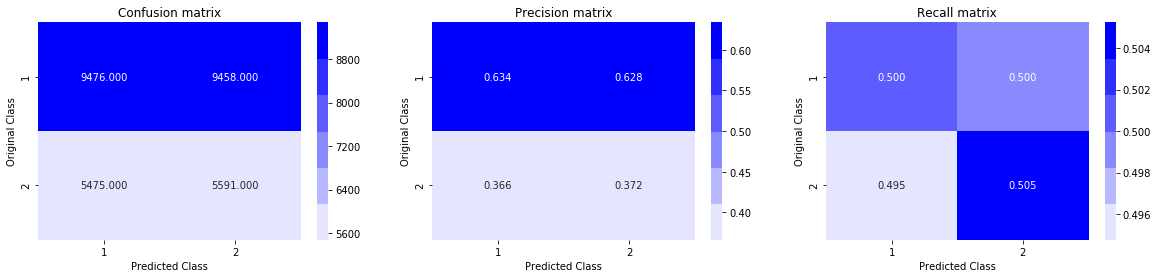

In [122]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

## 4.4 Logistic Regression with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.5888947581351776
For values of alpha =  0.0001 The log loss is: 0.6095646612770589
For values of alpha =  0.001 The log loss is: 0.5972604572829663
For values of alpha =  0.01 The log loss is: 0.6097511487777212
For values of alpha =  0.1 The log loss is: 0.5887912781564004
For values of alpha =  1 The log loss is: 0.5944146352712321
For values of alpha =  10 The log loss is: 0.6084859920380432


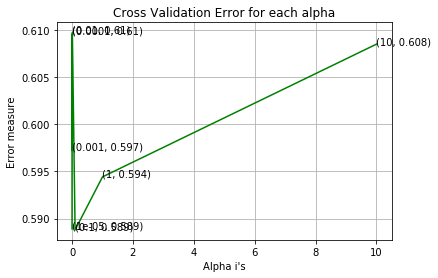

For values of best alpha =  0.1 The train log loss is: 0.5905450855423732
For values of best alpha =  0.1 The test log loss is: 0.5887912781564004
Total number of data points : 30000


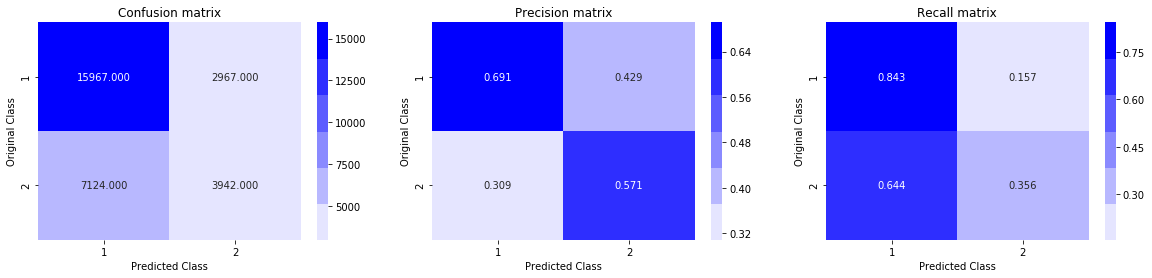

In [123]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_vect, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_vect, y_train)
    predict_y = sig_clf.predict_proba(test_vect)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_vect, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_vect, y_train)

predict_y = sig_clf.predict_proba(train_vect)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_vect)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
log_reg_logloss = log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## Linear SVM with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.5673884521166273
For values of alpha =  0.0001 The log loss is: 0.5739379765650561
For values of alpha =  0.001 The log loss is: 0.5890796725378581
For values of alpha =  0.01 The log loss is: 0.5986089380769096
For values of alpha =  0.1 The log loss is: 0.6057725668280558
For values of alpha =  1 The log loss is: 0.6250823912065081
For values of alpha =  10 The log loss is: 0.6153418835272535


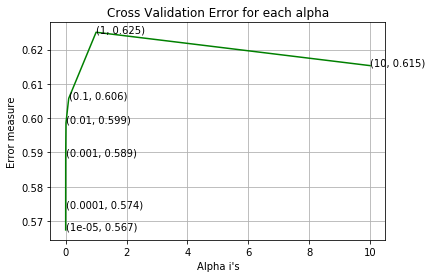

For values of best alpha =  1e-05 The train log loss is: 0.570678753403499
For values of best alpha =  1e-05 The test log loss is: 0.5673884521166273
Total number of data points : 30000


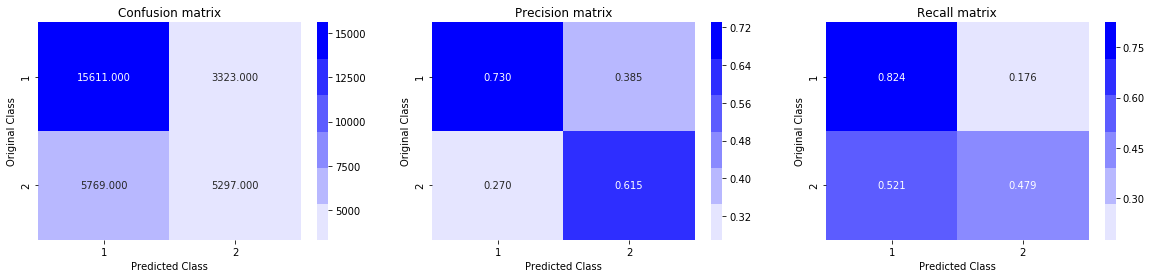

In [124]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(train_vect, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_vect, y_train)
    predict_y = sig_clf.predict_proba(test_vect)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(train_vect, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_vect, y_train)

predict_y = sig_clf.predict_proba(train_vect)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_vect)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
lr_svm_logloss = log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## XGBoost

In [125]:
def apply_spacy_w2v(quest_data, word2tfidf):

    # en_vectors_web_lg, which includes over 1 million unique vectors.
    nlp = spacy.load('en_core_web_sm')

    vecs1 = []
    # https://github.com/noamraph/tqdm
    # tqdm is used to print the progress bar
    for qu1 in tqdm(quest_data):
        doc1 = nlp(qu1) 
        # 384 is the number of dimensions of vectors 
        mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
        for word1 in doc1:
            # word2vec
            vec1 = word1.vector
            # fetch df score
            try:
                idf = word2tfidf[str(word1)]
            except:
                idf = 0
            # compute final vec
            mean_vec1 += vec1 * idf
        mean_vec1 = mean_vec1.mean(axis=0)
        vecs1.append(mean_vec1)
    return vecs1

In [126]:
def apply_w2v_xgboost(train_df, test_df):
    
    # Train data
    train_question = train_df['question1'] + train_df['question2']
    
    train_special_feat = train_df[['cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio']]
    
    train_question_vect = apply_spacy_w2v(train_question, word2tfidf_train)
    
    train_question_vect = hstack([train_question_vect, train_special_feat])
    
    std_scalar = StandardScaler(with_mean=False)
    
    train_question_vect = std_scalar.fit_transform(train_question_vect)
    
    
    #Test data
    test_question = test_df['question1'] + test_df['question2']
    
    test_special_feat = test_df[['cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio']]
    
    test_question_vect = apply_spacy_w2v(test_question, word2tfidf_test)
    
    test_question_vect = hstack([test_question_vect, test_special_feat])
    
    test_question_vect = std_scalar.transform(test_question_vect)
    
    return train_question_vect, test_question_vect

In [127]:
train_vect, test_vect = apply_w2v_xgboost(x_train, x_test)

100%|██████████| 30000/30000 [05:56<00:00, 84.24it/s]


In [128]:
# Source: https://gist.github.com/wrwr/3f6b66bf4ee01bf48be965f60d14454d

param_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5, 1],
    'max_depth': [2, 4, 8, 16],
    'min_child_weight': [2, 4, 6, 8, 10],
    'subsample': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'n_estimators': [32, 64, 128, 256, 512],
    'reg_alpha': [0.001, 0.01, 0.05, 0.1, 0.5]
}

In [129]:
clf = xgb.XGBClassifier(objective= 'binary:logistic', eval_metric='logloss', n_jobs=-1)

rs_clf = RandomizedSearchCV(clf, param_grid, n_jobs=-1, verbose=1, cv=10, scoring='neg_log_loss',
                            refit=True, return_train_score=True, random_state=42)

rs_clf.fit(train_vect, y_train)

learning_rate_best = rs_clf.best_params_.get('learning_rate')
print('learning_rate_best: ', learning_rate_best)
max_depth_best = rs_clf.best_params_.get('max_depth')
print('max_depth_best: ', max_depth_best)
min_child_weight_best = rs_clf.best_params_.get('min_child_weight')
print('min_child_weight_best: ', min_child_weight_best)
subsample_best = rs_clf.best_params_.get('subsample')
print('subsample_best: ', subsample_best)
colsample_bytree_best = rs_clf.best_params_.get('colsample_bytree')
print('colsample_bytree_best: ', colsample_bytree_best)
colsample_bylevel_best = rs_clf.best_params_.get('colsample_bylevel')
print('colsample_bylevel_best: ', colsample_bylevel_best)
reg_alpha_best = rs_clf.best_params_.get('reg_alpha')
print('reg_alpha_best: ', reg_alpha_best)
n_estimators_best = rs_clf.best_params_.get('n_estimators')
print('n_estimators_best: ', n_estimators_best)
gamma_best = rs_clf.best_params_.get('gamma')
print('gamma_best: ', gamma_best)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 26.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 43.5min finished


learning_rate_best:  0.2
max_depth_best:  16
min_child_weight_best:  2
subsample_best:  0.6
colsample_bytree_best:  0.4
colsample_bylevel_best:  None
reg_alpha_best:  0.5
n_estimators_best:  128
gamma_best:  0.1


In [134]:
best_clf = xgb.XGBClassifier(objective= 'binary:logistic', eval_metric='logloss', learning_rate = learning_rate_best, 
                             max_depth = max_depth_best, subsample = subsample_best, reg_alpha = reg_alpha_best,
                             colsample_bytree = colsample_bytree_best, n_estimators = n_estimators_best,
                             min_child_weight = min_child_weight_best, gamma = gamma_best, n_jobs=-1)

best_clf.fit(train_vect, y_train)

print("The train log loss is:",log_loss(y_train,  best_clf.predict_proba(train_vect), labels=best_clf.classes_, eps=1e-15))

# predict_y = best_clf.predict_proba(test_vect)

xgb_logloss = log_loss(y_test, best_clf.predict_proba(test_vect), labels=best_clf.classes_, eps=1e-15)

print("The test log loss is:",log_loss(y_test, best_clf.predict_proba(test_vect), labels=best_clf.classes_, eps=1e-15))

The train log loss is: 0.03043585211129999
The test log loss is: 0.3899816930650792


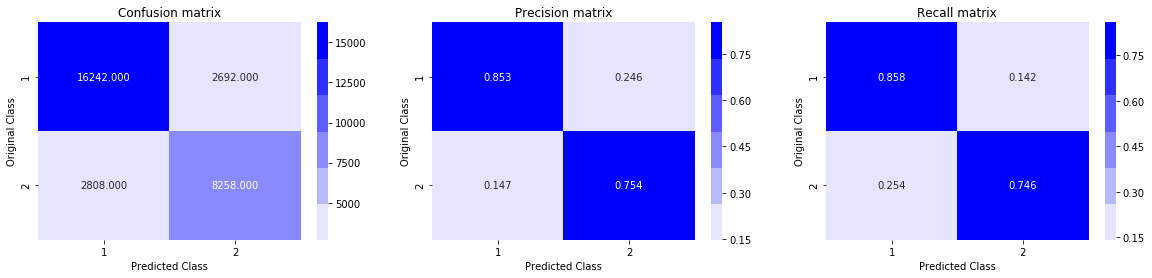

In [135]:
plot_confusion_matrix(y_test, best_clf.predict(test_vect))

In [136]:
from prettytable import PrettyTable

model_metric = PrettyTable()

model_metric = PrettyTable(["Model Name", "Test Log-Loss", ])

model_metric.add_row(["Logistic regression", log_reg_logloss])
model_metric.add_row(["Linear SVM", lr_svm_logloss])
model_metric.add_row(["XGBoost", xgb_logloss])

print(model_metric)

+---------------------+--------------------+
|      Model Name     |   Test Log-Loss    |
+---------------------+--------------------+
| Logistic regression | 0.5887912781564004 |
|      Linear SVM     | 0.5673884521166273 |
|       XGBoost       | 0.3899816930650792 |
+---------------------+--------------------+


## Steps

1) Read data from the 'train.csv' file get useful info about all the columns using 'data.info()'. Later plot the number of distribution of data points among output classes bar plot.

2) Get the useful insights from the data as mentioned below:
    a)  Number of unique and repeated questions
    b) Checking for Duplicates 
    c) Number of occurrences of each question
    d) NULL values in each column

3) Extracting the following basic features before cleaning
    
    -> freq_qid1 = Frequency of qid1's
    -> freq_qid2 = Frequency of qid2's
    -> q1len = Length of q1
    -> q2len = Length of q2
    -> q1_n_words = Number of words in Question 1
    -> q2_n_words = Number of words in Question 2
    -> word_Common = (Number of common unique words in Question 1 and Question 2)
    -> word_Total =(Total num of words in Question 1 + Total num of words in Question 2)
    -> word_share = (word_common)/(word_Total)
    -> freq_q1+freq_q2 = sum total of frequency of qid1 and qid2
    -> freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2
    
4) Analysis of some of the extracted features:
    
    -> Minimum length of the questions in question1 :  1
    -> Minimum length of the questions in question2 :  1
    -> Number of Questions with minimum length [question1] : 67
    -> Number of Questions with minimum length [question2] : 24
    -> Feature: word_share
    -> Feature: word_Common
    
5) Preprocessing:
    
    -> Removing html tags
    -> Removing Punctuations
    -> Performing stemming
    -> Removing Stopwords
    -> Expanding contractions etc.

6) Advanced Feature Extraction (NLP and Fuzzy Features):

    -> cwc_min : Ratio of common_word_count to min lenghth of word count of Q1 and Q2 

    -> cwc_min = common_word_count / (min(len(q1_words), len(q2_words))

    -> cwc_max : Ratio of common_word_count to max lenghth of word count of Q1 and Q2 

    -> cwc_max = common_word_count / (max(len(q1_words), len(q2_words))

    -> csc_min : Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 

    -> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))

    -> csc_max : Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2

    -> csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))

    -> ctc_min : Ratio of common_token_count to min lenghth of token count of Q1 and Q2

    -> ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))

    -> ctc_max : Ratio of common_token_count to max lenghth of token count of Q1 and Q2

    -> ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))

    -> last_word_eq : Check if First word of both questions is equal or not

    -> last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])

    -> first_word_eq : Check if First word of both questions is equal or not

    -> first_word_eq = int(q1_tokens[0] == q2_tokens[0])

    -> abs_len_diff : Abs. length difference

    -> abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))

    -> mean_len : Average Token Length of both Questions

    -> mean_len = (len(q1_tokens) + len(q2_tokens))/2

    -> fuzz_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

    -> fuzz_partial_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

    -> token_sort_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

    -> token_set_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

    -> longest_substr_ratio : Ratio of length longest common substring to min lenghth of token count of Q1 and Q2

    -> longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))
    

7) Analysis of extracted features:
    
    -> Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
    
    -> Pair plot for features 'ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'
    
    -> Dimentionality reduction for 15 Features using t-SNE
  

8) Sampling preprocessed data and splitting data into train and test sets.

9) Filling the null values with ' '

10) Applying TF-IDF on both train and test data. Also a dictionary with feature names and idf scores for both train and test data

11) Building a random model for worst-case log-loss scenario

12) Plotting Confusion matrix, Presision matrix and Recall matrix for the random model

13) Building Logistic Regression with hyperparameter tuning with TF-IDF vectors and plotting the Confusion, Presision and Recall matrix for the same.

14) Building Linear SVM with hyperparameter tuning with TF-IDF vectors and plotting the Confusion, Presision and Recall matrix for the same.

15) Applying XGBoost with hyperparameter tuning with TF-IDF W2V(using Spacy) vectors and plotting the Confusion, Presision and Recall matrix for the same.

16) Plotting the PrettyTable comparing test log-loss of all 3 models.